# NWM Reanalysis Use Case

## Provide use case for comparing the performance of the NWM for modeling the water depth to the USGS station observation. 

In [1]:
from reanalysis import get_reanalysis_paths_gs, data_access_gs, plotReanalysis
import gcsfs
import json
import os
import urllib3
import xarray as xr
import pandas as pd
from glob import glob
from time import time
from IPython.display import IFrame
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


%matplotlib inline

C:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def open_station_website(USGS_ID:str, start_date:str, end_date:str) -> IFrame:
    '''Open the selected USGS station website. Users can use this website to prepare the required parameters for retrieving the desired records.'''
    return IFrame(src=f"https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=gif_default&site_no={USGS_ID}&period=&begin_date={start_date}&end_date={end_date}", width='100%', height='500px')

In [3]:
def usgs_data(station_id:str, start_date:str, end_date:str, parameter:str) -> dict:
    '''Retrieve time series data for a USGS gauge.'''
        
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    http = urllib3.PoolManager()

    # Define URL parameters    
    data_format = "json"
    station_id = station_id
    start_date = start_date
    end_date = end_date
    parameter = parameter
    site_type = "ST"
    site_status = "all"
    
    # Build the URL to retrieve the data
    st_service_url = "https://nwis.waterservices.usgs.gov/nwis/iv/?format="+ data_format +\
    "&sites="+ station_id +"&startDT="+ start_date +"&endDT="+ end_date +"&parameterCd="+ parameter +\
    "&siteType="+ site_type +"&siteStatus="+ site_status
    url = http.request('GET', st_service_url).data
    response = json.loads(url)
    usgs_values = response['value']['timeSeries'][0]['values'][0]['value']
    
    # usgs_values = {'value': value in str, 'qualifiers': qualifiers in str, 'dateTime': dateTime in str}
    return usgs_values

In [4]:
def get_NWM_rc(comid, rc_filepath=r"data/hydroprop-fulltable2D.nc") -> (interp1d, pd.DataFrame):
    """Opens the hydroprop-fulltable2D.nc file and retireves rating curves.
    This is available for download at: 
    https://web.corral.tacc.utexas.edu/nfiedata/hydraulic-property-table/.
    More information can be found at: https://web.corral.tacc.utexas.edu/nfiedata/.
    """
    ds = xr.open_dataset(rc_filepath)
    dis_ds = ds.Discharge.sel(CatchId=comid)
    dis_df = dis_ds.to_dataframe().reset_index().drop(columns=["CatchId"]).dropna()
    f = interp1d(dis_df.Discharge, dis_df.Stage, kind="cubic")
    return f, dis_df

In [5]:
def new_plot(x_label='Time (hr)', y_label='Discharge (cfs)', figsize=(20,6), fontsize=18) -> plt.subplots:
    '''Return a created new plotframe.'''
    
    fig,  ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=2)
    return fig, ax

## Identify use case parameters and target start and end dates

In [6]:
USGS_ID = '02087570' # USGS 02087570 NEUSE RIVER AT SMITHFIELD, NC

comid = 8785685 # NWM stream comid where the USGS station located. It is the same stream comid in the NHDPlus dataset.

start_date = '2016-10-05'
end_date = '2016-10-15'

freq = "1H"

# NWM rating curve NetCDF file path 
nwm_rc_path = r"C:\Users\mmorsy\Documents\GitHub\fcast\notebooks\data\hydroprop-fulltable2D.nc"

## Observation

In [7]:
open_station_website(USGS_ID, start_date, end_date)

### Based on the available station observation, decide which observation parameter to retrieve

In [8]:
parameter = "00065"  # USGS Gage Height Code

### USGS observation retrieval

In [9]:
usgs_values = usgs_data(USGS_ID, start_date, end_date, parameter)
usgs_df = pd.DataFrame.from_records(usgs_values)
usgs_df.head()

,dateTime,qualifiers,value
0,2016-10-05T00:00:00.000-04:00,[A],7.37
1,2016-10-05T00:15:00.000-04:00,[A],7.36
2,2016-10-05T00:30:00.000-04:00,[A],7.36
3,2016-10-05T00:45:00.000-04:00,[A],7.35
4,2016-10-05T01:00:00.000-04:00,[A],7.33


In [10]:
# clean-up and post-process the observation
usgs_df = usgs_df[usgs_df.value != '-999999']
usgs_df['dateTime'] =  pd.to_datetime(usgs_df['dateTime'], utc=False)
usgs_df['value']= pd.to_numeric(usgs_df['value'])

if parameter == "00065":
    usgs_df['value']= usgs_df['value'] * 0.3048 #if stage, multiply by 0.3048 to change the units from feet to meter
    
if  parameter == "00060":
    usgs_df['value']= pd.to_numeric(usgs_df['value']) * 0.028316847 #if discharge, multiply by 0.028316847 to change the units from cfs to cms

usgs_df = usgs_df.assign(increment_hr = usgs_df.dateTime.diff())
usgs_df.head()

,dateTime,qualifiers,value,increment_hr
0,2016-10-05 00:00:00-04:00,[A],2.246376,NaT
1,2016-10-05 00:15:00-04:00,[A],2.243328,00:15:00
2,2016-10-05 00:30:00-04:00,[A],2.243328,00:15:00
3,2016-10-05 00:45:00-04:00,[A],2.240280,00:15:00
4,2016-10-05 01:00:00-04:00,[A],2.234184,00:15:00


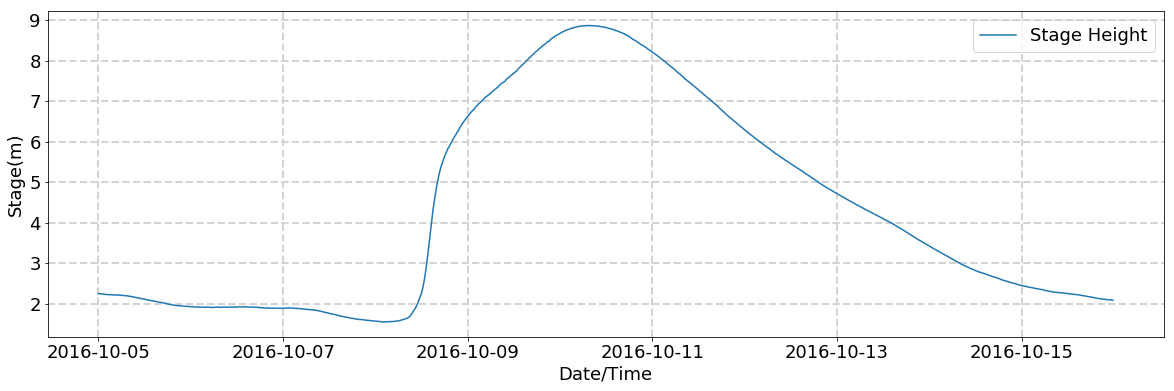

In [11]:
fig, ax = new_plot(x_label='Date/Time', y_label='Stage(m)')
ax.plot(usgs_df.dateTime, usgs_df.value, label="Stage Height")
ax.legend(fontsize=18)

## national-water-model-v2 reanalysis data

### Prepare the list of the files to access through gs

In [12]:
target_analysis = 'full_physics' # Choose between: 1) full_physics; 2) long_range
gs_paths = get_reanalysis_paths_gs(start_date, end_date, freq, target_analysis=target_analysis)

### Choose between two methods to access the data: 1) 'real-time' (default); 2) 'download'.
#### If the second method is chosen, please provide the target local directory to download the data. 
#### By default, the local directory to store the downloaded data is './data'

In [13]:
all_data = data_access_gs(gs_paths, gs_access_method='download')

753.75 seconds to download 10.670910636 GB of data for the given duration


## Begin exploration

In [14]:
NWM_df = all_data.sel(feature_id=comid)['streamflow'].to_dataframe().drop(columns=['feature_id', 'latitude', 'longitude'])
NWM_df.head()

,streamflow
time,
2016-10-05 00:00:00,29.239999
2016-10-05 01:00:00,29.159999
2016-10-05 02:00:00,29.089999
2016-10-05 03:00:00,29.029999
2016-10-05 04:00:00,28.959999


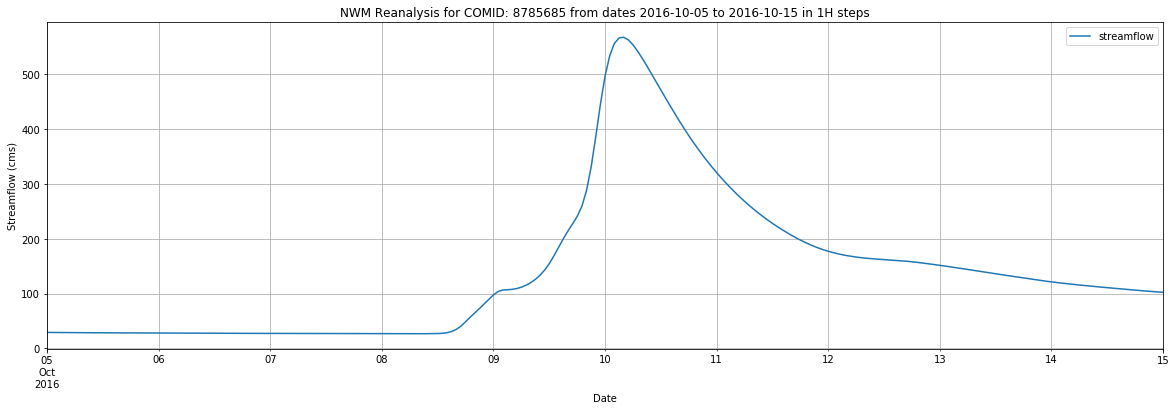

In [15]:
plotReanalysis(NWM_df, comid, freq)

In [16]:
# get the NWM rating curve for the given comid
ds = xr.open_dataset(nwm_rc_path)
f, nwm_rc = get_NWM_rc(comid, nwm_rc_path)
nwm_rc.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,0.293121
2,0.6096,0.987556
3,0.9144,2.014828
4,1.2192,3.333481


In [17]:
f(0.293121)

array(0.30479972)

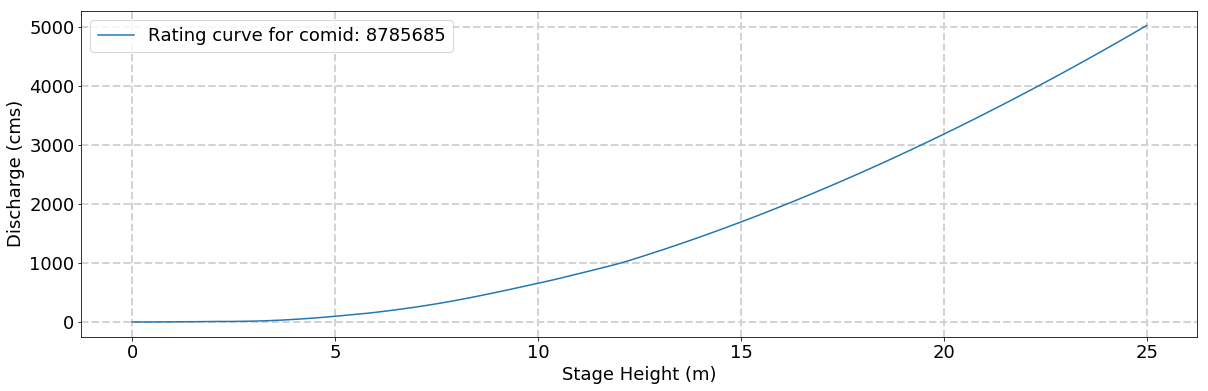

In [18]:
fig, ax = new_plot(x_label='Stage Height (m)', y_label='Discharge (cms)')
ax.plot(nwm_rc.Stage, nwm_rc.Discharge, label=f"Rating curve for comid: {comid}")
ax.legend(fontsize=18)

## Convert the NWM modeled discharge to water depth using the retrieved rating curve

In [19]:
NWM_stage_df = NWM_df.apply(f).rename(columns={'streamflow': 'stage'})
NWM_stage_df.head()

,stage
time,
2016-10-05 00:00:00,3.633636
2016-10-05 01:00:00,3.632522
2016-10-05 02:00:00,3.631543
2016-10-05 03:00:00,3.630698
2016-10-05 04:00:00,3.629707


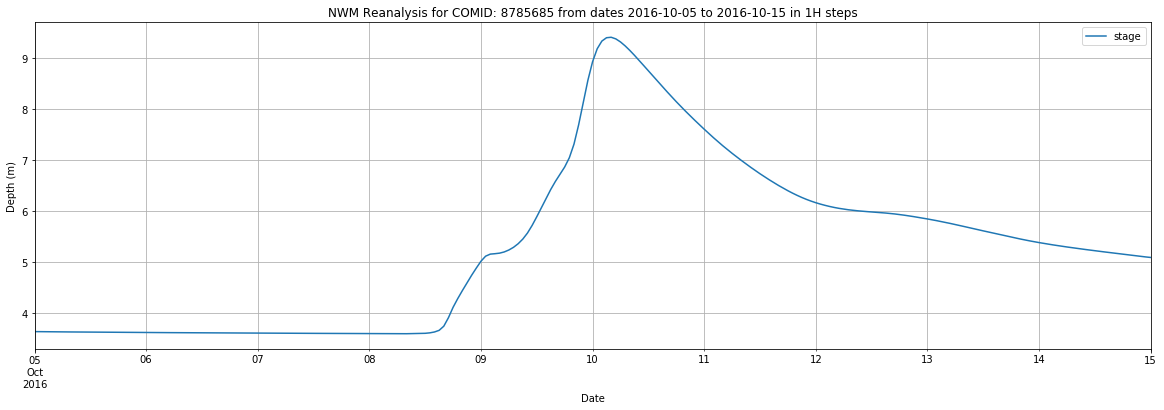

In [20]:
plotReanalysis(NWM_stage_df, comid, freq, flow=False)

## Compare the USGS observed stage height with the NWM modeled water depth

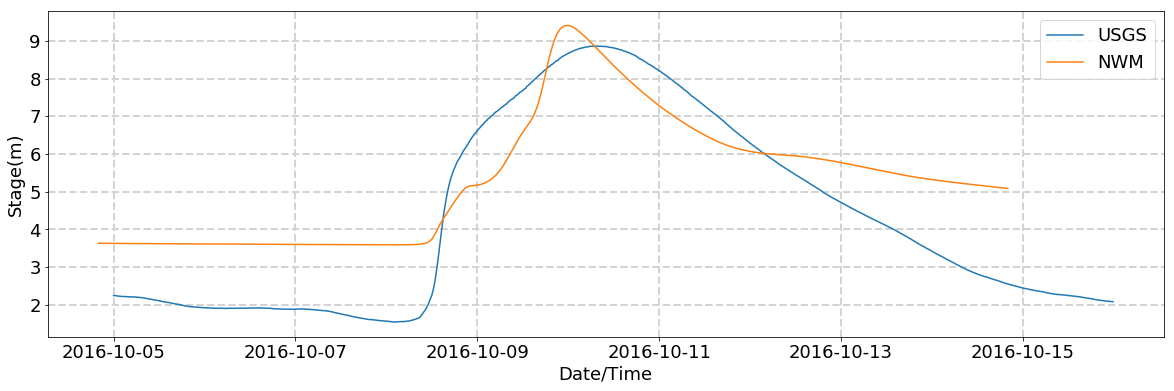

In [22]:
fig, ax = new_plot(x_label='Date/Time', y_label='Stage(m)')
ax.plot(usgs_df.dateTime, usgs_df.value, label="USGS")
ax.plot(NWM_stage_df, label="NWM")
ax.legend(fontsize=18)

# End